# Cleaning Regression: Normalization

This notebook explores the effect of normalization on the regression-based autoencoder approach.

In [80]:
# Importing some libraries

# Torch 
import torch
from torch import nn
import torch.nn.functional as F
from torchview import draw_graph

# Other libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import jaccard_score

**Unpacking the data**

In this first part, some functions are defined to unpack the data.

In [81]:
class CPU_Unpickler(pickle.Unpickler):
    # to avoid errors that occur when loading pickle files on cpu that were originally saved using a gpu
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [82]:
# Function that enables you to unpack a certain chunk of data
def load_chunk_file(file_path, chunk_i):
    with open(file_path+f'chunk_{chunk_i}', 'rb') as file:
            loaded_data = CPU_Unpickler(file).load()
            
    return loaded_data

In [83]:
# The locations of the data
file_path_noisy = '/lustre/fs23/group/cta/users/amehta/summer_student_data/noisy_images/'
file_path_true = '/lustre/fs23/group/cta/users/amehta/summer_student_data/true_images/'

# Unpack 100 chunks of data
chunk_tot = 100

data_noisy_tot = np.array([])
data_true_tot = np.array([])

for chunk_i in range(0,chunk_tot):
    data_noisy_all = load_chunk_file(file_path_noisy, chunk_i)
    mask_gamma_ray = np.array((data_noisy_all[1]==1))
    data_noisy_chunk = np.array(data_noisy_all[0])[mask_gamma_ray]
    data_noisy_tot = np.append(data_noisy_tot, data_noisy_chunk)
    
    data_true_all = load_chunk_file(file_path_true, chunk_i)
    data_true_chunk = np.array(data_true_all[0])[mask_gamma_ray]
    data_true_tot = np.append(data_true_tot, data_true_chunk)
    
# Get it in the right shape
data_noisy = data_noisy_tot.reshape(64*chunk_tot, 56, 56)
data_true = data_true_tot.reshape(64*chunk_tot, 56, 56)


In [84]:
N_examples = len(data_noisy)
print(f"Number of images: {N_examples}")

Number of images: 6400


**Exploratory Data Analysis**

In this section, we have a look at some of the noisy and true data.

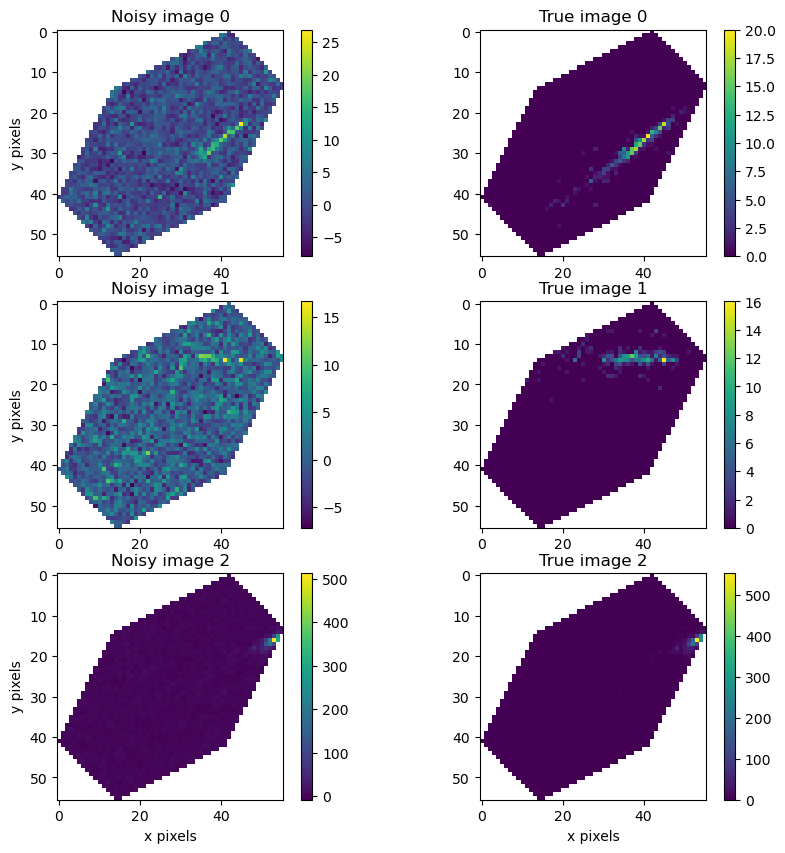

In [85]:
n_images = 3 # Compare 3 examples

fig, axs = plt.subplots(n_images, 2, figsize=(10,10))

for i in range(0,n_images):
    im_noisy = axs[i,0].imshow(data_noisy[i])
    axs[i,0].set_title(f"Noisy image {i}")
    axs[i,0].set_ylabel("y pixels")
    plt.colorbar(im_noisy, ax=axs[i,0])
    
    im_true = axs[i,1].imshow(data_true[i])
    axs[i,1].set_title(f"True image {i}")
    plt.colorbar(im_true, ax=axs[i,1])
    
    
axs[i,0].set_xlabel("x pixels")
axs[i,1].set_xlabel("x pixels")

plt.show()

**Data Preperation**

In [7]:
# Make a mask of the locations of the nans, so that we can put them back in after fitting.

nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)
data_true_nonan = np.nan_to_num(data_true)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification

threshold = 0

#data_true_binary = np.zeros((64*chunk_tot, 56, 56))
#data_true_binary[data_true>threshold] = 1
#data_true_binary_flat = data_true_binary.reshape((64*chunk_tot, 56*56))
data_true_nonan_flat = data_true_nonan.reshape((64*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy[images_high_mask]

data_noisy_tensor = (torch.from_numpy(data_noisy_nonan[images_high_mask]).float())
data_true_tensor = (torch.from_numpy(data_true_nonan_flat[images_high_mask])).float()

data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()
data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_noisy_train = data_noisy_tensor[:idx_split]
data_true_train = data_true_tensor[:idx_split]
data_noisy_test = data_noisy_tensor[idx_split:]
data_true_test = data_true_tensor[idx_split:]

data_noisy_train_im = data_noisy_tensor_im[:idx_split]
data_true_train_im = data_true_tensor_im[:idx_split]
data_noisy_test_im = data_noisy_tensor_im[idx_split:]
data_true_test_im = data_true_tensor_im[idx_split:]


In [10]:
# Batch form
batch_size = 1

N, H, W = data_noisy_train.shape
N_new = N//batch_size

data_noisy_train_batch = data_noisy_train[:int(N_new*batch_size)].reshape(N_new, batch_size, 1, H, W)
data_true_train_batch = data_true_train[:int(N_new*batch_size)].reshape(N_new, batch_size, H*W)

**The Autoencoder Model**

In [11]:
# AE with 4 layers

class AE4(nn.Module):
    def __init__(self):
        super().__init__()
        
        second_layer = 75
            
        # Encoder functions
        self.conv1a = nn.Conv2d(1, 10, kernel_size=(3,3), padding='same')
        self.conv1b = nn.Conv2d(10, 10, kernel_size=(3,3), padding='same')
        self.conv2a = nn.Conv2d(10, second_layer, kernel_size=(3,3), padding='same')
        self.conv2b = nn.Conv2d(second_layer, second_layer, kernel_size=(3,3), padding='same')
        
        # Decoder functions
        self.deconv1a = nn.ConvTranspose2d(second_layer, second_layer, kernel_size=(3,3), padding=1)
        self.deconv1b = nn.ConvTranspose2d(second_layer, 10, kernel_size=(3,3), padding=1)
        self.deconv2a = nn.ConvTranspose2d(10, 10, kernel_size=(3,3), padding=1)
        self.deconv2b = nn.ConvTranspose2d(10, 1, kernel_size=(3,3), padding=1)
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)
            
        N = (x.shape)[0]
        
        # Encoder part
        x = F.relu(self.conv1a(x))
        x = self.conv1b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = F.relu(self.conv2a(x))
        x = self.conv2b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv1a(x))
        x = F.relu(self.deconv1b(x))
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv2a(x))
        x = self.deconv2b(x)
        
        # Get the right shape
        x = x.squeeze(0)
        
        if N==1:
            x = x.reshape(1, 56*56)
        else:
            x = x.reshape(batch_size, 56*56)
        
        return x         

**Define functions for the training and the testing**

In [12]:
learning_rate = 0.0005

network = AE4()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

In [13]:
# Functions and definitions for 
n_epochs = 3

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

batch_size=1
weight = 2

# This is the main training loop
def train(epoch):
    network.train()
    
    i=0
    train_loss = 0
    
    random_indices = torch.randperm(len(data_noisy_train))
    data_noisy_train_clone = torch.clone(data_noisy_train)
    data_true_train_clone = torch.clone(data_true_train)
    
    data_noisy_train[random_indices] = data_noisy_train_clone
    data_true_train[random_indices] = data_true_train_clone
    
    for noisy, true in zip(data_noisy_train, data_true_train):
        noisy = noisy.unsqueeze(0)
        true = true.unsqueeze(0)
        
        i=i+1
        optimizer.zero_grad()
        output = network(noisy)
        weights = torch.tensor([weight])
        loss = F.mse_loss(output, true)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*batch_size
    train_losses.append(train_loss/len(data_noisy_train))
    print('Training set: Avg. loss: {:.4f}'.format(train_loss/len(data_noisy_train)))

# This is the main testing loop
def test():
    network.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy, true in zip(data_noisy_test, data_true_test):
            noisy = noisy.unsqueeze(0)
            true = true.unsqueeze(0)
            
            i=i+1
            output = network(noisy)
            weights = torch.tensor([weight])
            loss = F.mse_loss(output, true)
            test_loss += loss.item()
            #output_data = F.sigmoid(output.data)
            #output_binary = output_data.round()
    
    test_loss /= len(data_noisy_test)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}'.format(test_loss))

**Unnormalized**

In [14]:
%%time

n_epochs = 50

learning_rate = 0.0001

network = AE4()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 65.8172
Training set: Avg. loss: 1824.9556

Test set: Avg. loss: 47.7355
Training set: Avg. loss: 1273.6809

Test set: Avg. loss: 30.2096
Training set: Avg. loss: 1086.8575

Test set: Avg. loss: 29.7273
Training set: Avg. loss: 944.3589

Test set: Avg. loss: 25.0763
Training set: Avg. loss: 945.2832

Test set: Avg. loss: 25.3293
Training set: Avg. loss: 806.0956

Test set: Avg. loss: 41.8604
Training set: Avg. loss: 1140.5271

Test set: Avg. loss: 22.5679
Training set: Avg. loss: 670.3513

Test set: Avg. loss: 23.6870
Training set: Avg. loss: 722.0897

Test set: Avg. loss: 34.7047
Training set: Avg. loss: 762.0684

Test set: Avg. loss: 28.0236
Training set: Avg. loss: 700.4865

Test set: Avg. loss: 18.5878
Training set: Avg. loss: 447.3908

Test set: Avg. loss: 19.6181
Training set: Avg. loss: 608.4913

Test set: Avg. loss: 45.0504
Training set: Avg. loss: 710.8066

Test set: Avg. loss: 19.5620
Training set: Avg. loss: 658.2369

Test set: Avg. loss: 18.5921
Traini

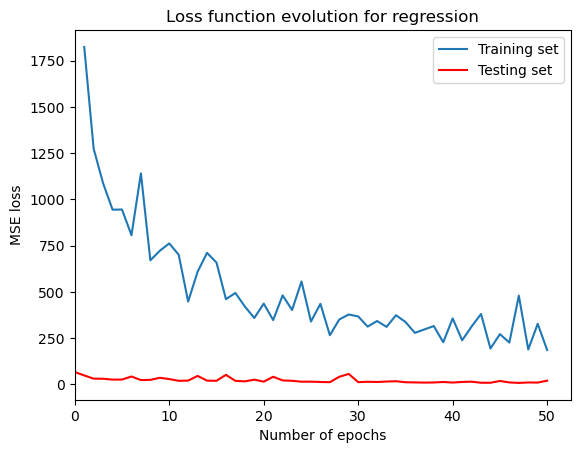

In [15]:
plt.figure()

plt.title("Loss function evolution for regression")
plt.plot(train_counter, train_losses, label='Training set')
plt.plot(test_counter, test_losses, color='red', label='Testing set')
plt.xlabel("Number of epochs")
plt.ylabel("MSE loss")
plt.xlim(0,)
#plt.ylim(0,100)
plt.legend()

plt.show()

In [16]:
print(train_losses)
print(test_losses)

[1824.9555765341684, 1273.680869938302, 1086.8574506151708, 944.358850178836, 945.2832178606369, 806.0956228929222, 1140.5270767445395, 670.3512792752707, 722.0897296791821, 762.0683948723208, 700.4865448210094, 447.3907830978499, 608.4913245910536, 710.8066435601343, 658.2369301067221, 460.3695815831627, 493.73415376034677, 420.7289175891775, 358.5055496863401, 436.14292560877277, 347.14747650772733, 481.0028844739768, 401.7495705180442, 556.0206742208825, 339.30237724139135, 435.08637346212714, 265.3135047392017, 350.6141765948409, 377.27989052717686, 366.7677238126224, 311.8117409287347, 341.99352016062085, 310.2761618343719, 373.44731241919976, 337.0198456020681, 277.89499489306843, 296.4676312478633, 314.74593801715275, 227.13029792277146, 356.1026462667336, 237.70367625729168, 312.02889760255493, 380.12998024206996, 193.1467777812126, 271.1685850919296, 225.29407803278724, 479.26376946137066, 188.0441121540041, 326.87466211153276, 184.93620522776214]
[65.81720021062368, 47.735497

Noisy max: 30.178312301635742
Clean max: 27.233293533325195
Noisy max: 21.168087005615234
Clean max: 16.207847595214844
Noisy max: 57.44615173339844
Clean max: 51.27919006347656


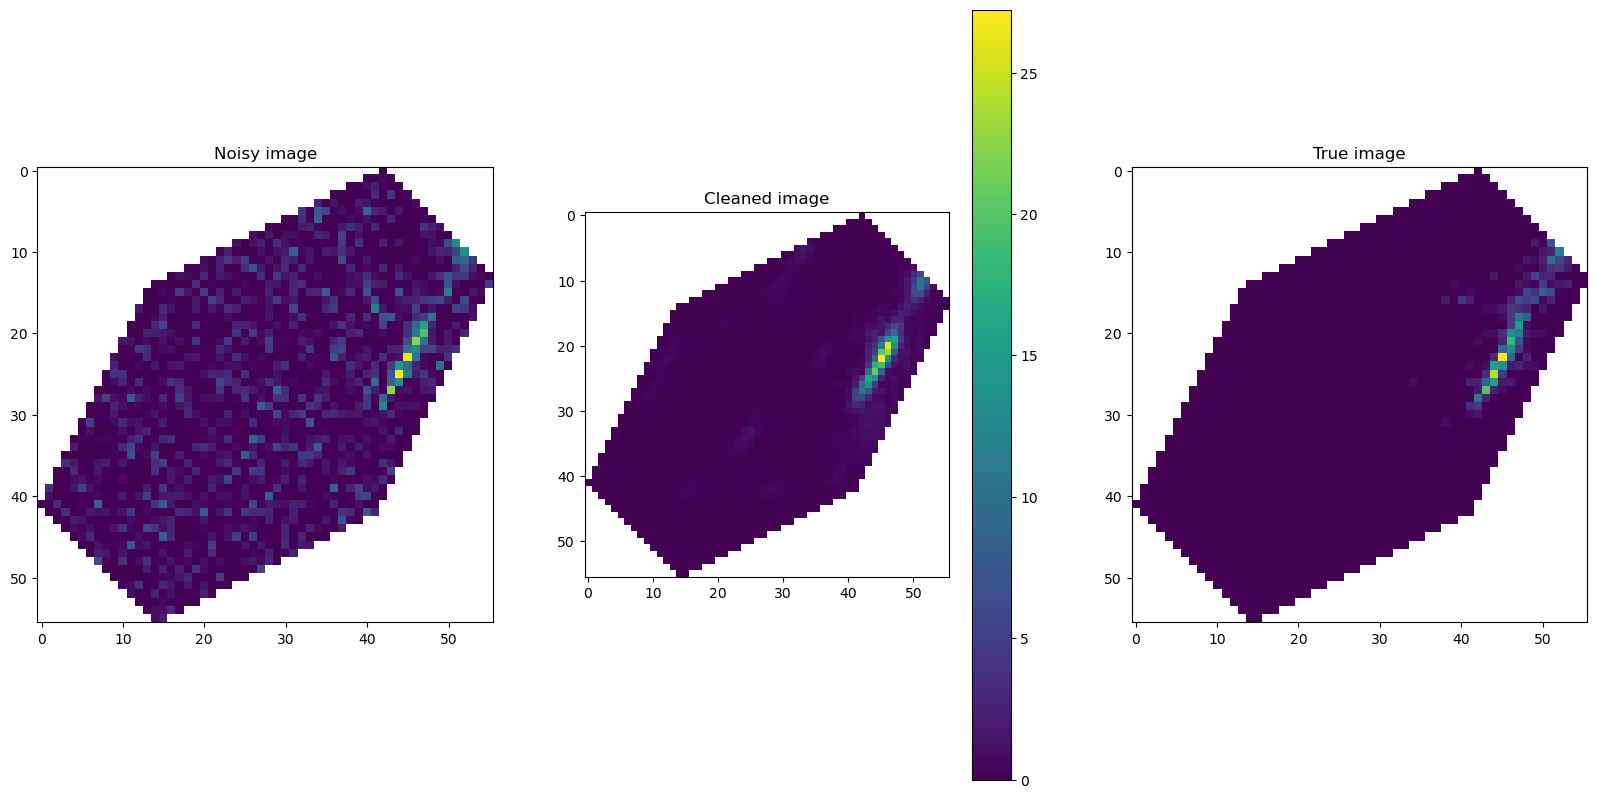

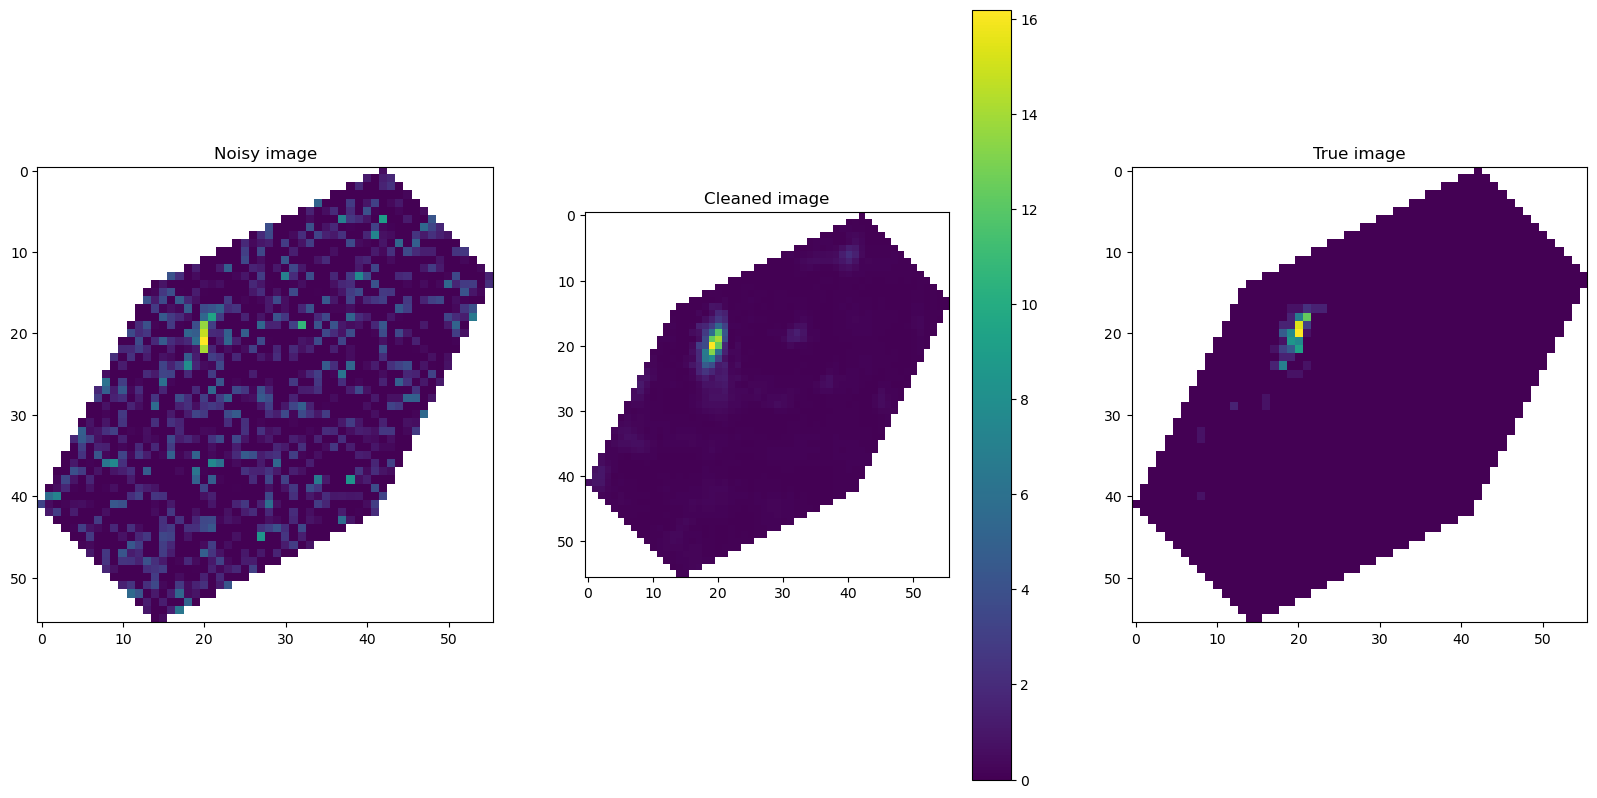

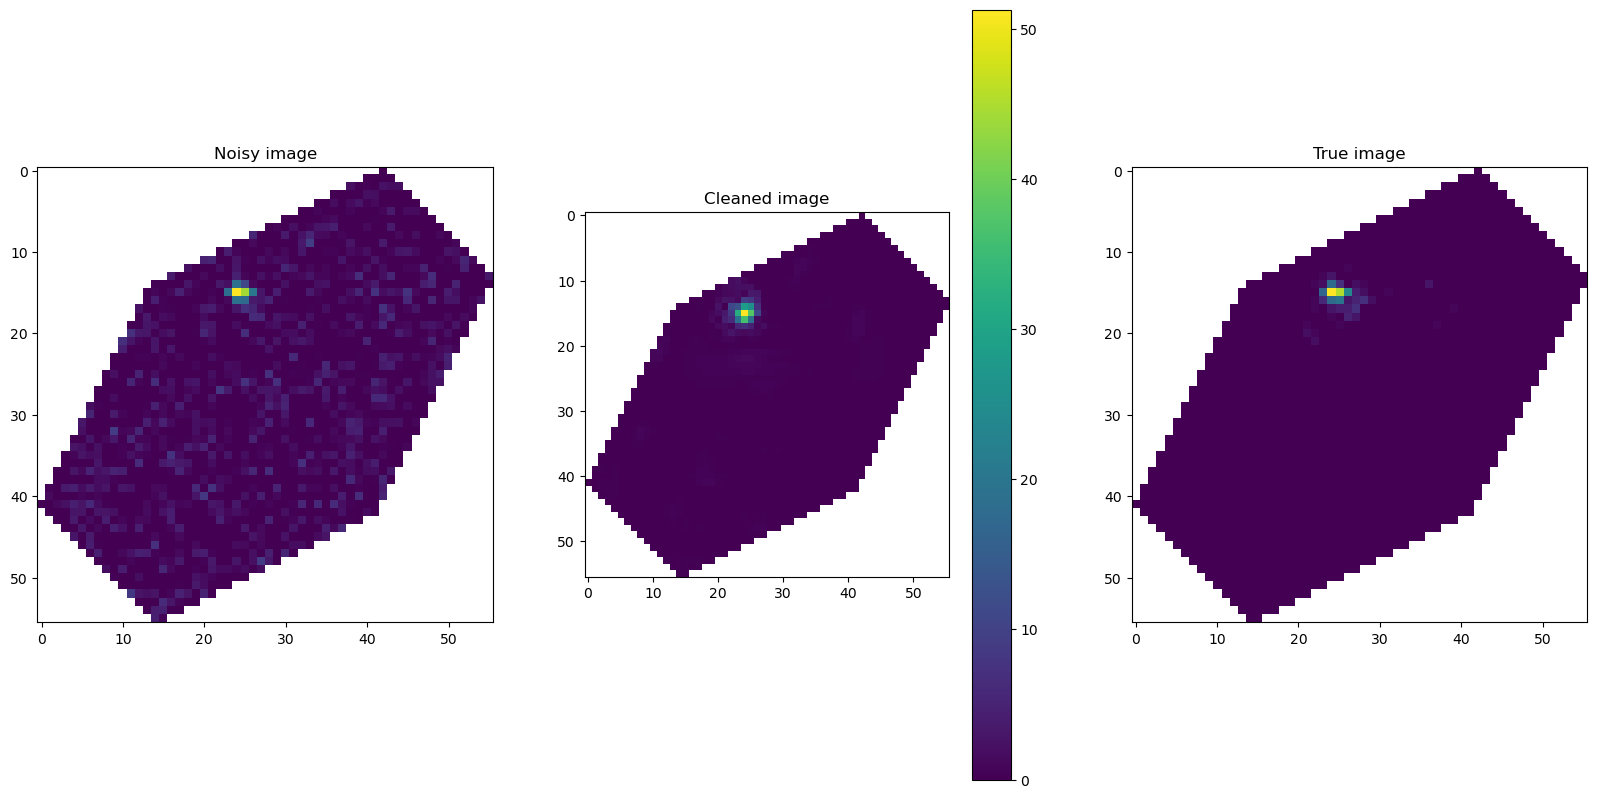

In [17]:
n_start = 0
n_im = 3

for im_i in range(n_start, n_start+n_im):
    output = network(data_noisy_test[im_i].unsqueeze(0))


    im_clean = (output.data).reshape(56, 56)

    
    im_clean[nan_mask] = np.nan
    
    fig, axs = plt.subplots(1,3,figsize=(20,10))

    fig_noisy = axs[0].imshow(data_noisy_test_im[im_i], vmin=0)
    axs[0].set_title("Noisy image")

    fig_clean = axs[1].imshow(im_clean.detach().numpy(), vmin=0)
    axs[1].set_title("Cleaned image")
    fig.colorbar(fig_clean, ax=axs[1])

    fig_true = axs[2].imshow(data_true_test_im[im_i], vmin=0)
    axs[2].set_title("True image")
    

plt.show()    

**With normalization**

In [86]:
# Make a mask of the locations of the nans, so that we can put them back in after fitting.

nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)
data_true_nonan = np.nan_to_num(data_true)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification

threshold = 0

#data_true_binary = np.zeros((64*chunk_tot, 56, 56))
#data_true_binary[data_true>threshold] = 1
#data_true_binary_flat = data_true_binary.reshape((64*chunk_tot, 56*56))
data_true_nonan_flat = data_true_nonan.reshape((64*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy[images_high_mask]
#data_noisy_arr[np.nan_to_num(data_noisy_arr)<0] = 0


pix_max_noisy = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
pix_min_noisy = np.nanmin(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
data_noisy_norm = np.nan_to_num((data_noisy_arr - pix_min_noisy)/(pix_max_noisy-pix_min_noisy))
data_noisy_tensor = (torch.from_numpy(data_noisy_norm).float())

# Now normalize the true data in the same way as the noisy data

data_true_arr = data_true_nonan_flat[images_high_mask]
pix_max_true = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis]
pix_min_true = np.nanmin(data_noisy_arr, axis=(1,2))[:, np.newaxis]
data_true_norm = np.nan_to_num((data_true_arr - pix_min_true)/(pix_max_true-pix_min_true))
data_true_tensor = (torch.from_numpy(data_true_norm).float())

data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()

data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_noisy_train = data_noisy_tensor[:idx_split]
data_true_train = data_true_tensor[:idx_split]
data_noisy_test = data_noisy_tensor[idx_split:]
data_true_test = data_true_tensor[idx_split:]

data_noisy_train_im = data_noisy_tensor_im[:idx_split]
data_true_train_im = data_true_tensor_im[:idx_split]
data_noisy_test_im = data_noisy_tensor_im[idx_split:]
data_true_test_im = data_true_tensor_im[idx_split:]


In [87]:
# Now with a minimum of 0

nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)
data_true_nonan = np.nan_to_num(data_true)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification

threshold = 0

#data_true_binary = np.zeros((64*chunk_tot, 56, 56))
#data_true_binary[data_true>threshold] = 1
#data_true_binary_flat = data_true_binary.reshape((64*chunk_tot, 56*56))
data_true_nonan_flat = data_true_nonan.reshape((64*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy[images_high_mask]
data_noisy_arr[np.nan_to_num(data_noisy_arr)<0] = 0


pix_max_noisy = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
data_noisy_norm = np.nan_to_num(data_noisy_arr/pix_max_noisy)
data_noisy_tensor = (torch.from_numpy(data_noisy_norm).float())

# Now normalize the true data in the same way as the noisy data

data_true_arr = data_true_nonan_flat[images_high_mask]
pix_max_true = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis]
data_true_norm = np.nan_to_num(data_true_arr/pix_max_true)
data_true_tensor = (torch.from_numpy(data_true_norm).float())

data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()

data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_noisy_train = data_noisy_tensor[:idx_split]
data_true_train = data_true_tensor[:idx_split]
data_noisy_test = data_noisy_tensor[idx_split:]
data_true_test = data_true_tensor[idx_split:]

data_noisy_train_im = data_noisy_tensor_im[:idx_split]
data_true_train_im = data_true_tensor_im[:idx_split]
data_noisy_test_im = data_noisy_tensor_im[idx_split:]
data_true_test_im = data_true_tensor_im[idx_split:]


In [88]:
# Functions and definitions for 
n_epochs = 3

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

batch_size=1
weight = 2

# This is the main training loop
def train(epoch):
    network.train()
    
    i=0
    train_loss = 0
    
    random_indices = torch.randperm(len(data_noisy_train))
    data_noisy_train_clone = torch.clone(data_noisy_train)
    data_true_train_clone = torch.clone(data_true_train)
    
    data_noisy_train[random_indices] = data_noisy_train_clone
    data_true_train[random_indices] = data_true_train_clone
    
    for noisy, true in zip(data_noisy_train, data_true_train):
        noisy = noisy.unsqueeze(0)
        true = true.unsqueeze(0)
        
        i=i+1
        optimizer.zero_grad()
        output = network(noisy)
        weights = torch.tensor([weight])
        loss = F.mse_loss(output, true)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*batch_size
    train_losses.append(train_loss/len(data_noisy_train))
    print('Training set: Avg. loss: {:.6f}'.format(train_loss/len(data_noisy_train)))

# This is the main testing loop
def test():
    network.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy, true in zip(data_noisy_test, data_true_test):
            noisy = noisy.unsqueeze(0)
            true = true.unsqueeze(0)
            
            i=i+1
            output = network(noisy)
            weights = torch.tensor([weight])
            #print(output.shape)
            #print(true.shape)
            loss = F.mse_loss(output, true)
            test_loss += loss.item()
            #output_data = F.sigmoid(output.data)
            #output_binary = output_data.round()
    
    test_loss /= len(data_noisy_test)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.6f}'.format(test_loss))

In [89]:
%%time

n_epochs = 50

learning_rate = 0.0001

network = AE4()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 0.065656
Training set: Avg. loss: 0.000883

Test set: Avg. loss: 0.000317
Training set: Avg. loss: 0.000313

Test set: Avg. loss: 0.000267
Training set: Avg. loss: 0.000273

Test set: Avg. loss: 0.000242
Training set: Avg. loss: 0.000251

Test set: Avg. loss: 0.000231
Training set: Avg. loss: 0.000237

Test set: Avg. loss: 0.000220
Training set: Avg. loss: 0.000226

Test set: Avg. loss: 0.000213
Training set: Avg. loss: 0.000218

Test set: Avg. loss: 0.000211
Training set: Avg. loss: 0.000210

Test set: Avg. loss: 0.000201
Training set: Avg. loss: 0.000204

Test set: Avg. loss: 0.000195
Training set: Avg. loss: 0.000199

Test set: Avg. loss: 0.000192
Training set: Avg. loss: 0.000192

Test set: Avg. loss: 0.000191
Training set: Avg. loss: 0.000188

Test set: Avg. loss: 0.000187
Training set: Avg. loss: 0.000183

Test set: Avg. loss: 0.000186
Training set: Avg. loss: 0.000180

Test set: Avg. loss: 0.000182
Training set: Avg. loss: 0.000176

Test set: Avg. loss: 0.0

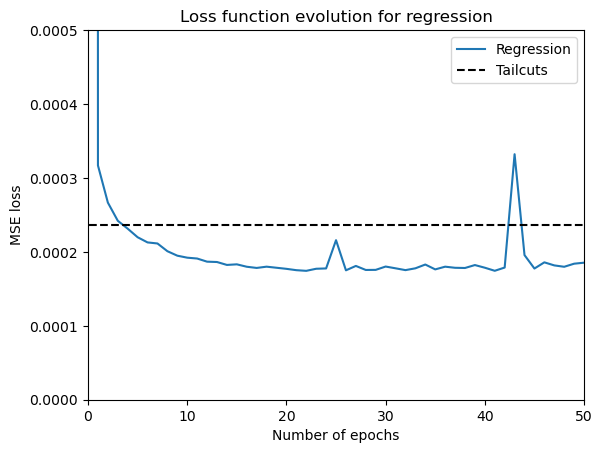

In [94]:
fig_reg=plt.figure()

plt.title("Loss function evolution for regression")
plt.plot(test_counter, test_losses, label='Regression')
plt.xlabel("Number of epochs")
plt.ylabel("MSE loss")
plt.xlim(0,50)
plt.ylim(0,0.0005)

# Only divided by pixmax
plt.hlines(0.00023664429947151884, -1, n_epochs+1, color='black', linestyles='--', label='Tailcuts')
plt.legend()

plt.show()


In [23]:
print(train_losses)
print(test_losses)

[0.0014265613327203942, 0.000381893842688506, 0.00030693258768005696, 0.0002738732826981593, 0.0002545475173234897, 0.00023840018256633121, 0.0002299904150637921, 0.00022159206758484815, 0.00021439797562855344, 0.00020774190075638338, 0.00020244381852064329, 0.00019833958444641616, 0.00019330809102647374, 0.00018907368608156715, 0.00018598206525268204, 0.0001816794114343758, 0.00017846905044828506, 0.0001761472000936588, 0.00017282423284709276, 0.00016924327268157648, 0.0001671268978507302, 0.00016452478942652305, 0.00016183018514545755, 0.00015963829497952202, 0.00015643317645944893, 0.00015505455641012935, 0.00015270294309911516, 0.0001506267709825372, 0.00014890024852210097, 0.00014655096769064906, 0.00014477952956102762, 0.00014286148299403072, 0.00014135671238261777, 0.00013965756891542408, 0.00013884691824751774, 0.00013670722296150355, 0.00013517063168173372, 0.00013304608480642526, 0.0001325311137682043, 0.00013092278450951156, 0.0001299288495341072, 0.0001285326297948096, 0.00

In [24]:
# From earlier from the notebook:

train_unnorm = np.array([1824.9555765341684, 1273.680869938302, 1086.8574506151708, 944.358850178836, 945.2832178606369, 806.0956228929222, 1140.5270767445395, 670.3512792752707, 722.0897296791821, 762.0683948723208, 700.4865448210094, 447.3907830978499, 608.4913245910536, 710.8066435601343, 658.2369301067221, 460.3695815831627, 493.73415376034677, 420.7289175891775, 358.5055496863401, 436.14292560877277, 347.14747650772733, 481.0028844739768, 401.7495705180442, 556.0206742208825, 339.30237724139135, 435.08637346212714, 265.3135047392017, 350.6141765948409, 377.27989052717686, 366.7677238126224, 311.8117409287347, 341.99352016062085, 310.2761618343719, 373.44731241919976, 337.0198456020681, 277.89499489306843, 296.4676312478633, 314.74593801715275, 227.13029792277146, 356.1026462667336, 237.70367625729168, 312.02889760255493, 380.12998024206996, 193.1467777812126, 271.1685850919296, 225.29407803278724, 479.26376946137066, 188.0441121540041, 326.87466211153276, 184.93620522776214])
test_unnorm = np.array([65.81720021062368, 47.73549752902958, 30.20962322445194, 29.72729650757238, 25.07627757282535, 25.329329616419404, 41.86037137668764, 22.567939386252863, 23.68700722582939, 34.704703372850545, 28.023560315136685, 18.58780162482117, 19.61810535975636, 45.05038946990609, 19.56200342325352, 18.5920986341655, 50.86153545763193, 18.343868761533045, 15.573891967027176, 24.70258599999507, 14.031561043043308, 40.44772211122807, 20.774737374564726, 18.49016599231838, 13.764862535205657, 14.029572105738481, 12.239886583200752, 11.079778999177062, 40.413587149048865, 55.7430913151647, 11.180071146161433, 13.390802967875794, 12.19220039353376, 14.584691787831852, 16.298115827931685, 10.861932000661511, 9.858585426475301, 8.859355377542865, 9.518616070822215, 12.141289633726325, 9.146385196152021, 12.2624755615878, 13.834155976324606, 8.062442372331704, 7.98054481215207, 17.662630409480077, 9.740774907619429, 7.115926845064345, 9.608037678092183, 8.954875593862994, 19.405869985047744])

train_norm = np.array([0.0014265613327203942, 0.000381893842688506, 0.00030693258768005696, 0.0002738732826981593, 0.0002545475173234897, 0.00023840018256633121, 0.0002299904150637921, 0.00022159206758484815, 0.00021439797562855344, 0.00020774190075638338, 0.00020244381852064329, 0.00019833958444641616, 0.00019330809102647374, 0.00018907368608156715, 0.00018598206525268204, 0.0001816794114343758, 0.00017846905044828506, 0.0001761472000936588, 0.00017282423284709276, 0.00016924327268157648, 0.0001671268978507302, 0.00016452478942652305, 0.00016183018514545755, 0.00015963829497952202, 0.00015643317645944893, 0.00015505455641012935, 0.00015270294309911516, 0.0001506267709825372, 0.00014890024852210097, 0.00014655096769064906, 0.00014477952956102762, 0.00014286148299403072, 0.00014135671238261777, 0.00013965756891542408, 0.00013884691824751774, 0.00013670722296150355, 0.00013517063168173372, 0.00013304608480642526, 0.0001325311137682043, 0.00013092278450951156, 0.0001299288495341072, 0.0001285326297948096, 0.00012694554967632984, 0.00012595414722279652, 0.0001244084269444416, 0.00012383530329320352, 0.0001221251298188218, 0.00012170682132969711, 0.00012037966227980051, 0.00011923691374906012])
test_norm = np.array([0.13593021192892785, 0.00041322787022797573, 0.00031162030562119467, 0.0002688306906026153, 0.0002433052609355926, 0.00022828654577496728, 0.0002253305588981618, 0.00021665304917128258, 0.00021060319935705622, 0.0002090131744697759, 0.00020161030602853093, 0.00019370910702923844, 0.00019242663047774466, 0.0002223207440219831, 0.0001859604198212324, 0.00018923191247051664, 0.00018300373419310643, 0.00018294423202187398, 0.0001807631093845481, 0.00018034191905116797, 0.00018205932323766598, 0.00017977437356286844, 0.0001759314917204074, 0.00017682170774144902, 0.00017753806377483994, 0.00019338485527429426, 0.0001825014788424074, 0.00017277697949912222, 0.0001776272649686228, 0.0001740979463835427, 0.00017301593577393853, 0.00017502437621354274, 0.00017277023434219256, 0.0001721893269382541, 0.000173465993690205, 0.00017186090797035157, 0.00017176620478062126, 0.00017726977344750084, 0.00017354786978592636, 0.00017308723285568213, 0.00017505576110565295, 0.00017441138849622932, 0.0001773597414868396, 0.00017545580819995084, 0.00017476705920161715, 0.00017917579822879803, 0.00017520908282929692, 0.00017567633796732423, 0.00017697310412027629, 0.0001781873815447308, 0.00017817605171106482])






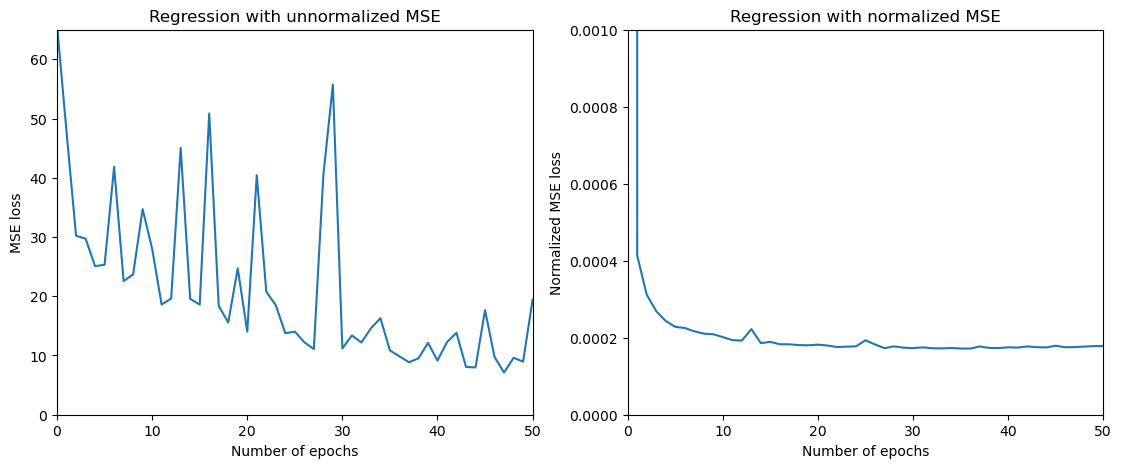

In [39]:
fig_norm, axs = plt.subplots(1,2,figsize=(13.5,5))

axs[0].plot(test_counter, test_unnorm, label='Testing set')
axs[0].set_title("Regression with unnormalized MSE")
axs[0].set_xlabel("Number of epochs")
axs[0].set_ylabel("MSE loss")
axs[0].set_ylim(0,65)
axs[0].set_xlim(0,50)

axs[1].plot(test_counter, test_norm, label='Testing set')
axs[1].set_title("Regression with normalized MSE")
axs[1].set_xlabel("Number of epochs")
axs[1].set_ylabel("Normalized MSE loss")
axs[1].set_ylim(0,0.001)
axs[1].set_xlim(0,50)

plt.show()

fig_norm.savefig("images/RegressionNorm.pdf")



tensor(-7.6815)
tensor(-7.4354)
tensor(-8.9058)


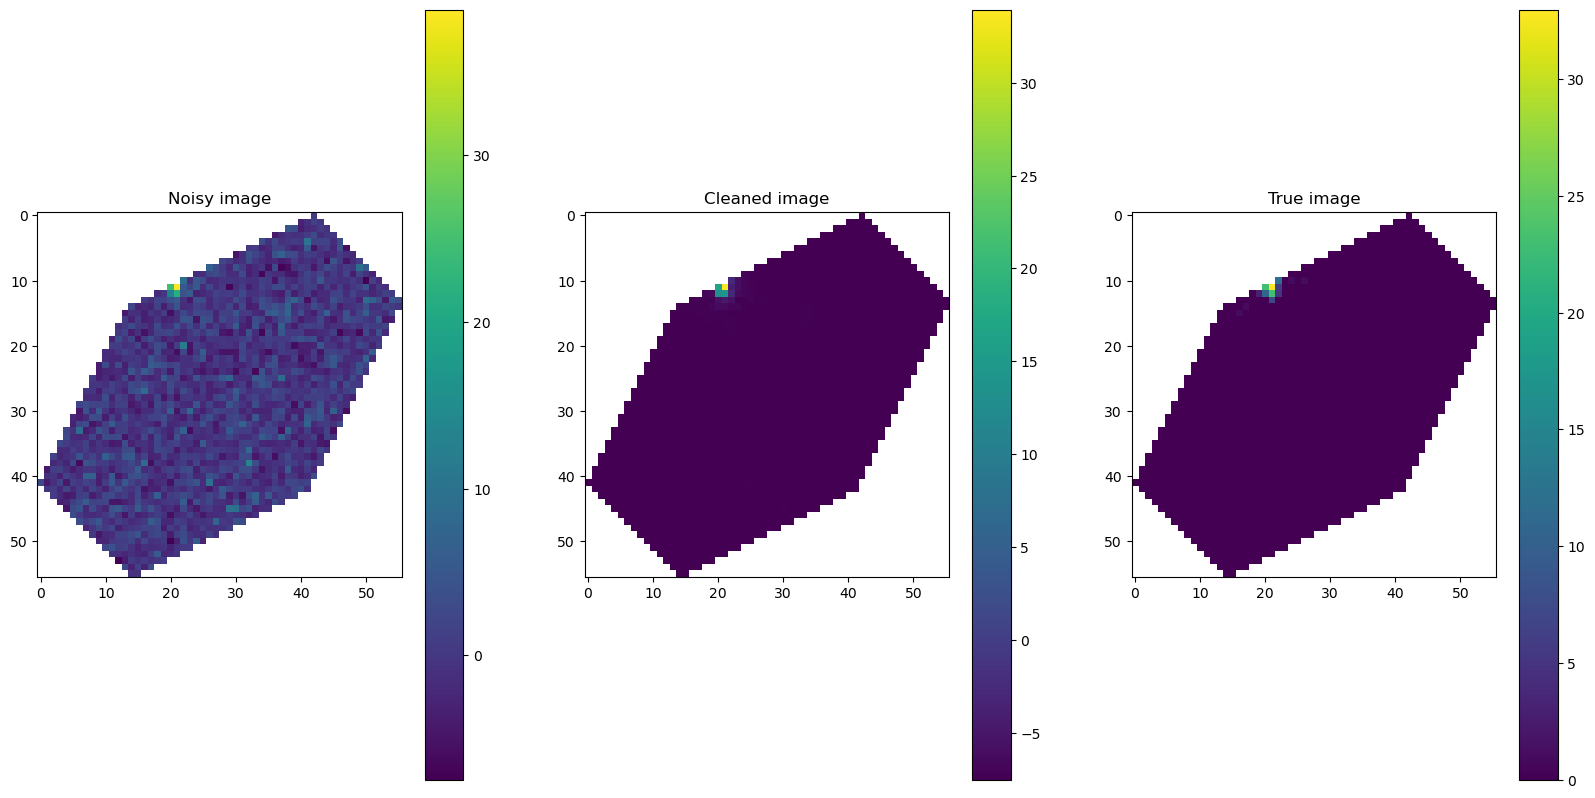

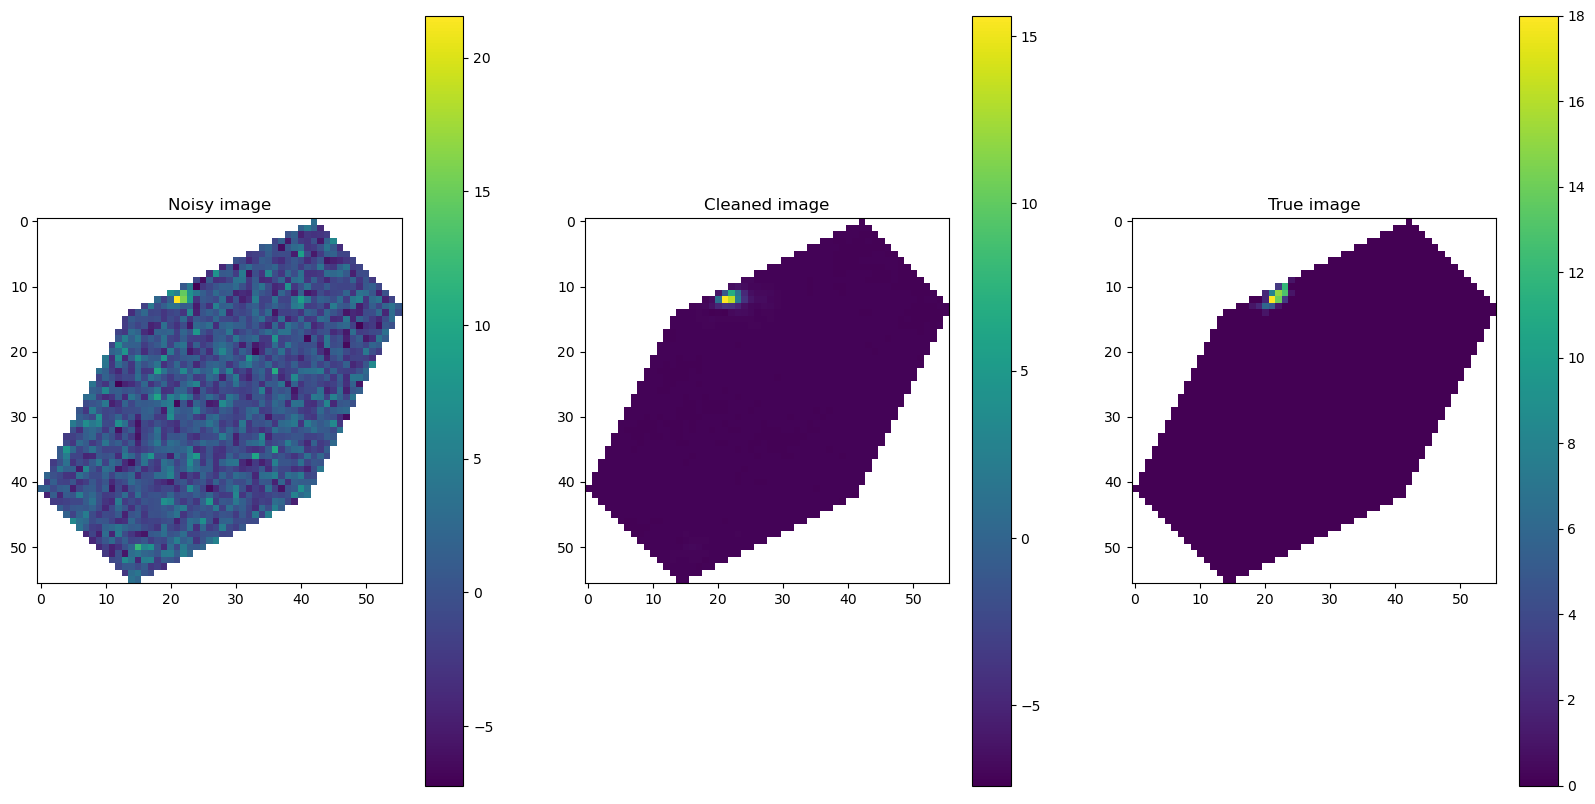

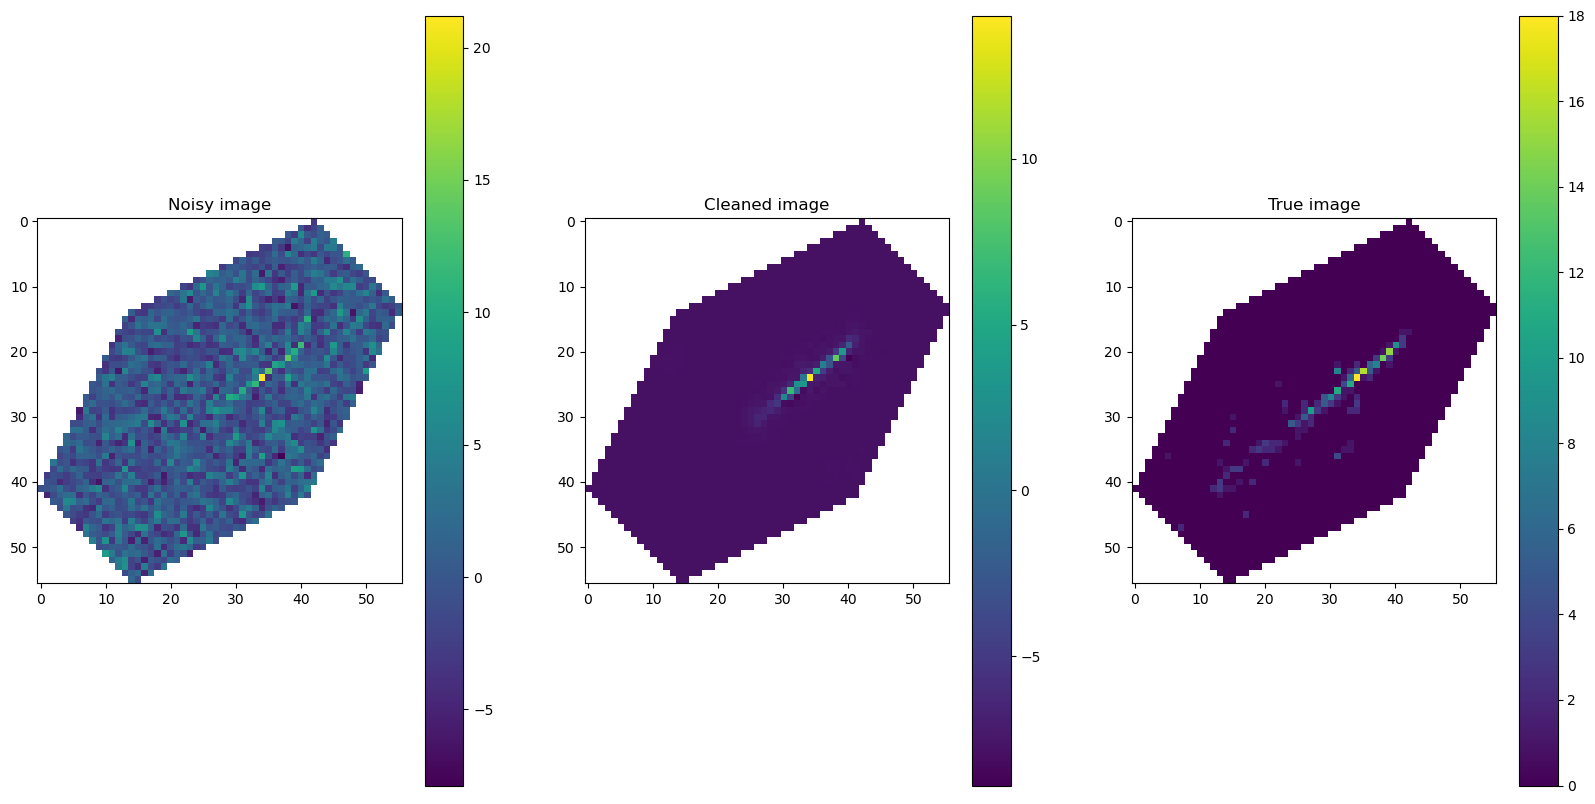

In [20]:
n_start = 3
n_im = 3

for im_i in range(n_start, n_start+n_im):
    output = network(data_noisy_test[im_i].unsqueeze(0))


    im_clean = (output.data).reshape(56, 56)
    
    im_clean = im_clean*(pix_max_noisy[idx_split+im_i][0][0]-pix_min_noisy[idx_split+im_i][0][0]) + pix_min_noisy[idx_split+im_i][0][0]
    im_clean[nan_mask] = np.nan
    
    fig, axs = plt.subplots(1,3,figsize=(20,10))

    fig_noisy = axs[0].imshow(data_noisy_test_im[im_i])#, vmin=0)
    axs[0].set_title("Noisy image")
    fig.colorbar(fig_noisy, ax=axs[0])

    fig_clean = axs[1].imshow(im_clean.detach().numpy())#, vmin=0)
    axs[1].set_title("Cleaned image")
    fig.colorbar(fig_clean, ax=axs[1])

    fig_true = axs[2].imshow(data_true_test_im[im_i])#, vmin=0)
    axs[2].set_title("True image")
    fig.colorbar(fig_true, ax=axs[2])

plt.show()    